In [1]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# datasets is a list of available datasets descriptions containing: path, key columns names, and suitable complex network features
from src.data.dataset_info import datasets


In [2]:
dataset = datasets[2]
name = dataset.name
print("dataset: {}".format(name))

path = "./datasets/partitions/{}.pkl".format(name)
new_path = "./datasets/preprocessed/{}.pkl".format(name)
graph_path = "./datasets/preprocessed/graph_{}.gexf".format(name)
df = pd.read_pickle(path)

dataset: partition_0


In [ ]:
# converting all infinity values into nan then dropping all records containing nan values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, how='any', inplace=True)

df.drop_duplicates(subset=list(set(df.columns) - set([dataset.timestamp_col, dataset.flow_id_col])), keep="first", inplace=True)

In [ ]:
total_count = len(df)

properties = {
    "name": dataset.name,
    "length": total_count,
}

num_benign = len(df[df['Label'] == 0])
num_attack = len(df[df['Label'] == 1])

properties["num_benign"] = num_benign
properties["percentage_of_benign_records"] = ((num_benign * 100)/total_count)

properties["num_attack"] = num_attack
properties["percentage_of_attack_records"] = ((num_attack * 100)/total_count)

properties["attacks"] = list(df["Attack"].unique())  # .to_list()

filename = ('./datasets_properties/{}.json'.format(dataset.name))
outfile = open(filename, 'w')
outfile.writelines(json.dumps(properties))
outfile.close()

In [ ]:
G = nx.from_pandas_edgelist(
        df,
        source=dataset.src_ip_col,
        target=dataset.dst_ip_col,
        create_using=nx.DiGraph()
    )

In [ ]:
G.remove_nodes_from(list(nx.isolates(G)))

In [ ]:
import igraph as ig
G1 = ig.Graph.from_networkx(G)
part = G1.community_infomap()

communities = []
for com in part:
    communities.append([G1.vs[node_index]['_nx_name'] for node_index in com])

print(f"==>> number of communities: {len(communities)}")
for com in communities:
    print(f"==>> com: {len(com)}")

In [ ]:
properties = {}

properties["number_of_nodes"] = G.number_of_nodes()
properties["number_of_edges"] = G.number_of_edges()

degrees = [degree for _, degree in G.degree()]
properties["max_degree"] = max(degrees)
properties["avg_degree"] = sum(degrees) / len(degrees)

In [ ]:
properties["transitivity"] = nx.transitivity(G)


In [ ]:
properties["density"] =  nx.density(G)


In [ ]:
# Assuming G is your graph and communities is a list of sets, where each set contains the nodes in a community

# Step 1: Map each node to its community
node_to_community = {}
for community_index, community in enumerate(communities):
    for node in community:
        node_to_community[node] = community_index

# Step 2: Count inter-cluster edges efficiently
inter_cluster_edges = 0
for u, v in G.edges():
    # Directly check if u and v belong to different communities
    if node_to_community[u] != node_to_community[v]:
        inter_cluster_edges += 1


properties["mixing_parameter"] = inter_cluster_edges / G.number_of_edges()

In [ ]:
properties["modularity"] = nx.community.modularity(G, communities)

In [ ]:
filename = ('./datasets_properties/{}.json'.format("graph_" + name))
outfile = open(filename, 'w')
outfile.writelines(json.dumps(properties))
outfile.close()

properties

In [ ]:
community_labels = {}
for i, community in enumerate(communities):
    for node in community:
        community_labels[node] = i

nx.set_node_attributes(G, community_labels, "new_community")

In [ ]:
# getting inter and itra graph, to calculate the local and global variations of each centrality
from src.network.network_features import separate_graph

intra_graph, inter_graph = separate_graph(G, communities)

In [ ]:
from src.network.network_features import cal_betweenness_centrality

if "betweenness" in dataset.cn_measures:
    nx.set_node_attributes(G, cal_betweenness_centrality(G), "betweenness")
    print("calculated")

In [ ]:
if "local_betweenness" in dataset.cn_measures:
    nx.set_node_attributes(G, cal_betweenness_centrality(intra_graph), "local_betweenness")
    print("calculated")

In [ ]:
if "global_betweenness" in dataset.cn_measures:
    nx.set_node_attributes(G, cal_betweenness_centrality(inter_graph), "global_betweenness")
    print("calculated")

In [ ]:
if "degree" in dataset.cn_measures:
    nx.set_node_attributes(G, nx.degree_centrality(G), "degree")
    print("calculated")

In [ ]:
if "local_degree" in dataset.cn_measures:
    nx.set_node_attributes(G, nx.degree_centrality(intra_graph), "local_degree")
    print("calculated")

In [ ]:
if "global_degree" in dataset.cn_measures:
    nx.set_node_attributes(G, nx.degree_centrality(inter_graph), "global_degree")
    print("calculated")

In [ ]:
if "eigenvector" in dataset.cn_measures:
    nx.set_node_attributes(G, nx.eigenvector_centrality(G, max_iter=600), "eigenvector")
    print("calculated")


In [ ]:
if "local_eigenvector" in dataset.cn_measures:
    nx.set_node_attributes(G, nx.eigenvector_centrality(intra_graph), "local_eigenvector")
    print("calculated")

In [ ]:
if "global_eigenvector" in dataset.cn_measures:
    nx.set_node_attributes(G, nx.eigenvector_centrality(inter_graph), "global_eigenvector")
    print("calculated")

In [ ]:
if "closeness" in dataset.cn_measures:
    nx.set_node_attributes(G, nx.closeness_centrality(G), "closeness")
    print("calculated")

In [ ]:
if "local_closeness" in dataset.cn_measures:
    nx.set_node_attributes(G, nx.closeness_centrality(intra_graph), "local_closeness")
    print("calculated")

In [ ]:
if "global_closeness" in dataset.cn_measures:
    nx.set_node_attributes(G, nx.closeness_centrality(inter_graph), "global_closeness")
    print("calculated")

In [ ]:
if "pagerank" in dataset.cn_measures:
    nx.set_node_attributes(G, nx.pagerank(G, alpha=0.85), "pagerank")
    print("calculated")

In [ ]:
if "local_pagerank" in dataset.cn_measures:
    nx.set_node_attributes(G, nx.pagerank(intra_graph, alpha=0.85), "local_pagerank")
    print("calculated")

In [ ]:
if "global_pagerank" in dataset.cn_measures:
    nx.set_node_attributes(G, nx.pagerank(inter_graph, alpha=0.85), "global_pagerank")
    print("calculated")

In [ ]:
from src.network.network_features import cal_k_core

if "k_core" in dataset.cn_measures:
    nx.set_node_attributes(G, cal_k_core(G), "k_core")
    print("calculated")

In [ ]:
from src.network.network_features import cal_k_truss
if "k_truss" in dataset.cn_measures:
    nx.set_node_attributes(G, cal_k_truss(G), "k_truss")
    print("calculated")

In [ ]:
from src.network.CommCentralityCode import comm_centreality

if "Comm" in dataset.cn_measures:
    nx.set_node_attributes(G, comm_centreality(G, community_labels), "Comm")
    print("calculated")

In [ ]:
from src.network.modularity_vitality import modularity_vitality

if "mv" in dataset.cn_measures:
    nx.set_node_attributes(G, modularity_vitality(G, part), "mv")
    print("calculated")

In [ ]:
nx.write_gexf(G, graph_path)

In [ ]:
features_dicts = {}
for measure in dataset.cn_measures:
    features_dicts[measure] = nx.get_node_attributes(G, measure)
    print(f"==>> features_dicts: {measure , len(features_dicts[measure])}")
    
for feature in dataset.network_features:
        if feature[:3] == "src":
            df[feature] = df.apply(
                lambda row: features_dicts[feature[4:]].get(row[dataset.src_ip_col], -1), axis=1)
        if feature[:3] == "dst":
            df[feature] = df.apply(
                lambda row: features_dicts[feature[4:]].get(row[dataset.dst_ip_col], -1), axis=1)

In [ ]:
df.head()

In [ ]:
pd.to_pickle(df, new_path)

In [6]:
dataset = datasets[3]
name = dataset.name
print("dataset: {}".format(name))

new_path = "./datasets/preprocessed/{}.pkl".format(name)
graph_path = "./datasets/preprocessed/graph_{}.gexf".format(name)
G = nx.read_gexf(graph_path)

dataset: partition_1


In [8]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import json
import seaborn as sns

from src.data.dataset_info import datasets
from sklearn.feature_selection import VarianceThreshold

# defining the thresholds
var_threshold = 0.00
corr_threshold = 0.75

# specifying the dataset
dataset = datasets[2]
name = dataset.name
print("dataset: {}".format(name))
path = "./datasets/preprocessed/{}.pkl".format(name)
# graph_path = "./datasets/preprocessed/graph_{}.gexf".format(name)

# loading the dataset as a Pandas dataframe
df = pd.read_pickle(path)

# We are only concerned with features used in training
df.drop(dataset.drop_columns, axis=1, inplace=True)
df.drop(dataset.label_col, axis=1, inplace=True)

dataset: partition_0


In [26]:
import networkx as nx

def check_missing_values(G, measures):

    missing_counts = {measure: 0 for measure in measures}
    
    for node in G.nodes():
        node_data = G.nodes[node]
        for measure in measures:
            if measure not in node_data or node_data[measure] is None:
                missing_counts[measure] += 1
    
    return missing_counts

print(check_missing_values(G, dataset.cn_measures))

{'betweenness': 0, 'local_betweenness': 77530, 'degree': 0, 'local_degree': 77530, 'eigenvector': 0, 'closeness': 0, 'pagerank': 0, 'local_pagerank': 77530, 'k_core': 0, 'k_truss': 0, 'Comm': 77530}


In [13]:
# Create a VarianceThreshold object
selector = VarianceThreshold(threshold=var_threshold)

# Fit the selector to the data and transform the data
data_filtered = selector.fit_transform(df)

# Get the names of the selected features
selected_features = df.columns[selector.get_support(indices=True)]

dropped_features = [col for col in df.columns if col not in selected_features]

# Create a new DataFrame with the selected features
data_filtered = pd.DataFrame(df, columns=selected_features)

# variances = np.var(df, axis=0)

print(f"==>> dropped_features by VarianceThreshold: {dropped_features}")

==>> dropped_features by VarianceThreshold: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Subflow Bwd Pkts']


Text(0.5, 1.0, 'Correlation Matrix Heatmap in dataset partition_0')

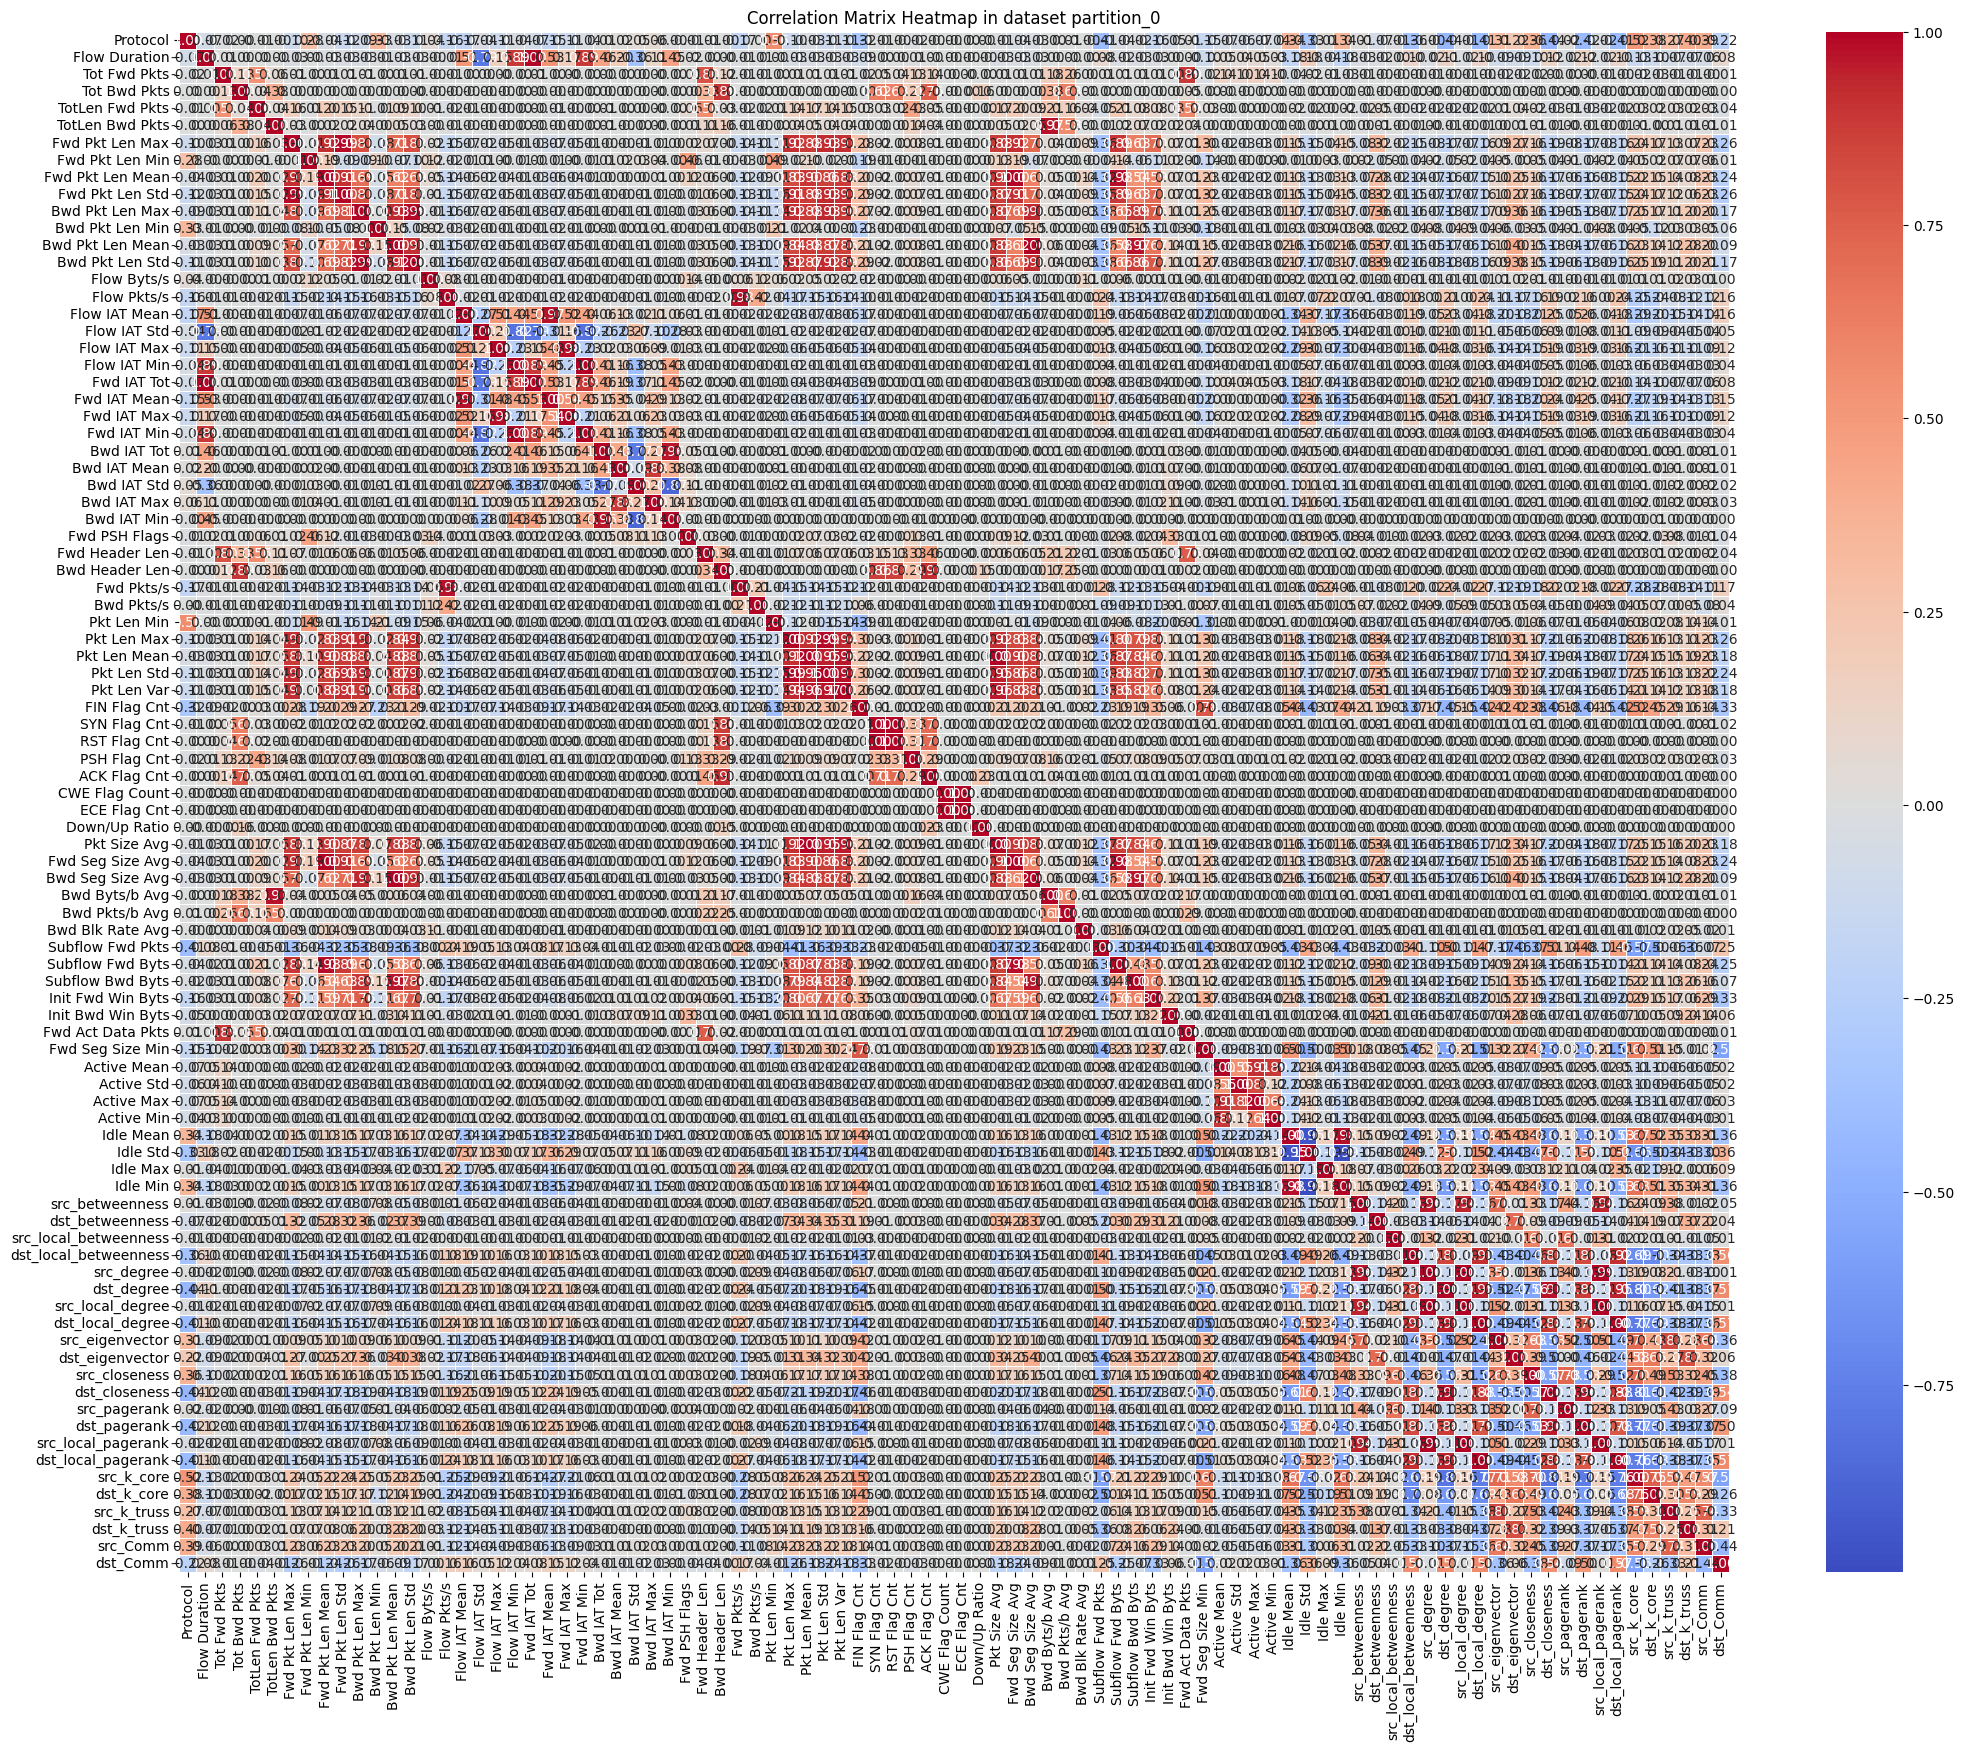

In [14]:
# create the correlation matrix
corr_matrix = data_filtered.corr()

# plotting the heatmap of the matrix
plt.figure(figsize=(25, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
            fmt='.2f', linewidths=.5)  # type: ignore
plt.title("Correlation Matrix Heatmap in dataset {}".format(dataset.name))
# plt.savefig(fname="visualization/{}/correlation_matrix".format(dataset.name))

In [15]:
# getting the top correlated features
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
correlated_features = [
    column for column in upper.columns if any(upper[column] > corr_threshold)]

# Drop only one feature from each highly correlated pair
features_to_remove = set()
for feature in correlated_features:
    correlated_with_feature = list(
        upper.index[upper[feature] > corr_threshold])
    for correlated_feature in correlated_with_feature:
        if correlated_feature not in features_to_remove:
            features_to_remove.add(correlated_feature)
            # features_to_remove.add(np.random.choice([feature, correlated_feature]))


# Drop the highly correlated features
data_filtered = data_filtered.drop(features_to_remove, axis=1)  # type: ignore

print(f"==>> dropped_features by correlation: {features_to_remove}")

==>> dropped_features by correlation: {'CWE Flag Count', 'Flow Duration', 'Active Mean', 'src_betweenness', 'Pkt Len Var', 'Fwd Pkt Len Mean', 'Active Std', 'dst_degree', 'src_k_core', 'TotLen Bwd Pkts', 'Pkt Size Avg', 'Flow IAT Min', 'dst_closeness', 'Flow Pkts/s', 'src_local_degree', 'Fwd Pkt Len Std', 'Pkt Len Std', 'Bwd Pkt Len Max', 'Pkt Len Max', 'Fwd IAT Tot', 'Idle Mean', 'Fwd Pkt Len Max', 'src_degree', 'Flow IAT Max', 'Bwd Pkt Len Std', 'Fwd Seg Size Avg', 'dst_local_degree', 'dst_pagerank', 'Bwd Pkt Len Mean', 'dst_eigenvector', 'Pkt Len Mean', 'Bwd Seg Size Avg', 'Fwd Header Len', 'SYN Flag Cnt', 'Bwd IAT Tot', 'Tot Fwd Pkts', 'Flow IAT Mean', 'Bwd IAT Mean', 'dst_local_betweenness', 'FIN Flag Cnt', 'Bwd Header Len', 'Tot Bwd Pkts', 'src_eigenvector'}


In [16]:
print(f"==>> final_features_names: {list(data_filtered.columns)}")

==>> final_features_names: ['Protocol', 'TotLen Fwd Pkts', 'Fwd Pkt Len Min', 'Bwd Pkt Len Min', 'Flow Byts/s', 'Flow IAT Std', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'dst_betweenness', 'src_local_betweenness', 'src_closeness', 'src_pagerank', 'src_local_pagerank', 'dst_local_pagerank', 'dst_k_core', 'src_k_truss', 'dst_k_truss', 'src_Comm', 'dst_Comm']


In [30]:
column_name = 'src_closeness'
first_100_values = data_filtered[column_name].head(20)  # Use .head(100) to get the first 100 values
print("First 100 values of column", column_name, ":")
print(first_100_values)

First 100 values of column src_Comm :
0     0.378480
1     0.161166
2     0.378480
3     0.200893
4     0.046966
5     0.471756
6     0.482713
7     0.336334
8     0.378480
9     0.482713
10    0.039464
11    0.161166
12    0.471756
13    0.471756
14    0.471756
15    0.471756
16    0.039464
17    0.378480
18    0.034853
19    0.378480
Name: src_Comm, dtype: float64


In [17]:
dropped_features.extend(list(features_to_remove))

In [18]:
print(f"==>> length of dropped_features: {len(dropped_features)}")

==>> length of dropped_features: 51


In [19]:
print(f"==>> dropped_features: {dropped_features}")

==>> dropped_features: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Subflow Bwd Pkts', 'CWE Flag Count', 'Flow Duration', 'Active Mean', 'src_betweenness', 'Pkt Len Var', 'Fwd Pkt Len Mean', 'Active Std', 'dst_degree', 'src_k_core', 'TotLen Bwd Pkts', 'Pkt Size Avg', 'Flow IAT Min', 'dst_closeness', 'Flow Pkts/s', 'src_local_degree', 'Fwd Pkt Len Std', 'Pkt Len Std', 'Bwd Pkt Len Max', 'Pkt Len Max', 'Fwd IAT Tot', 'Idle Mean', 'Fwd Pkt Len Max', 'src_degree', 'Flow IAT Max', 'Bwd Pkt Len Std', 'Fwd Seg Size Avg', 'dst_local_degree', 'dst_pagerank', 'Bwd Pkt Len Mean', 'dst_eigenvector', 'Pkt Len Mean', 'Bwd Seg Size Avg', 'Fwd Header Len', 'SYN Flag Cnt', 'Bwd IAT Tot', 'Tot Fwd Pkts', 'Flow IAT Mean', 'Bwd IAT Mean', 'dst_local_betweenness', 'FIN Flag Cnt', 'Bwd Header Len', 'Tot Bwd Pkts', 'src_eigenvector']


In [4]:
from autoencoder import extract_features, build_autoencoder
import numpy as np
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
network1_features = extract_features(G, dataset.cn_measures)

In [9]:
print(network1_features[:5])

[[0.00000000e+00 0.00000000e+00 1.28983993e-05 0.00000000e+00
  3.88312134e-11 1.28983993e-05 5.46592783e-06 1.05173431e-05
  1.11111111e-01 3.36134454e-03 2.13084148e-04]
 [0.00000000e+00 0.00000000e+00 2.57967986e-05 0.00000000e+00
  3.53011031e-12 0.00000000e+00 4.88756127e-06 1.05173431e-05
  2.22222222e-01 5.04201681e-03 1.96571356e-04]
 [0.00000000e+00 0.00000000e+00 1.10926234e-03 0.00000000e+00
  3.03942498e-09 1.10926234e-03 3.53064233e-04 1.05173431e-05
  1.11111111e-01 3.36134454e-03 1.38292483e-03]
 [0.00000000e+00 0.00000000e+00 1.28983993e-05 0.00000000e+00
  3.53011031e-12 0.00000000e+00 4.88756127e-06 1.05173431e-05
  1.11111111e-01 3.36134454e-03 1.97951397e-04]
 [0.00000000e+00 0.00000000e+00 2.57967986e-05 1.28983993e-05
  3.53011031e-12 0.00000000e+00 4.88756127e-06 2.42416101e-05
  2.22222222e-01 3.36134454e-03 2.10365363e-04]]


In [11]:
# Store input dimension
input_dim = len(dataset.cn_measures)  # Input dimension
# Build and train the autoencoder
autoencoder = build_autoencoder(input_dim)
# Early stopping
# early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
autoencoder.fit(network1_features, network1_features, epochs=200, batch_size=32, validation_split=0.2
)

Epoch 1/200


2025-04-16 11:02:31.749508: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1939/1939 [==============================] - 3s 1ms/step - loss: 0.0464 - val_loss: 0.0016
Epoch 2/200
1939/1939 [==============================] - 2s 1ms/step - loss: 8.9632e-04 - val_loss: 1.9432e-04
Epoch 3/200
1939/1939 [==============================] - 2s 1ms/step - loss: 7.1609e-05 - val_loss: 2.4154e-05
Epoch 4/200
1939/1939 [==============================] - 2s 1ms/step - loss: 2.5313e-05 - val_loss: 1.8764e-05
Epoch 5/200
1939/1939 [==============================] - 2s 1ms/step - loss: 1.2720e-05 - val_loss: 2.5288e-06
Epoch 6/200
1939/1939 [==============================] - 2s 1ms/step - loss: 6.4194e-06 - val_loss: 1.7030e-06
Epoch 7/200
1939/1939 [==============================] - 2s 1ms/step - loss: 6.0720e-06 - val_loss: 1.5447e-06
Epoch 8/200
1939/1939 [==============================] - 2s 1ms/step - loss: 5.9395e-06 - val_loss: 1.4305e-06
Epoch 9/200
1939/1939 [==============================] - 2s 1ms/step - loss: 5.8275e-06 - val_loss: 1.3329e-06
Epoch 10/200
1939/193

In [12]:
# Extract latent vectors
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
latent_vectors = encoder.predict(network1_features)

# Print latent vectors shape
print("Latent vectors shape:", latent_vectors.shape)

2423/2423 [==============================] - 2s 796us/step
Latent vectors shape: (77530, 8)


In [13]:
print(latent_vectors[:12])  # Print the first 5 rows


[[1.3176506  0.24424125 0.         0.00461589 0.9305158  0.
  1.788716   0.        ]
 [1.4439515  0.05089363 0.         0.20651203 1.1033361  0.
  1.8927135  0.        ]
 [1.3160088  0.2446409  0.         0.00328936 0.9295773  0.
  1.7856493  0.        ]
 [1.3176564  0.24423942 0.         0.0046232  0.9305264  0.
  1.7887415  0.        ]
 [1.4467391  0.05094361 0.         0.2043879  1.1061128  0.
  1.892894   0.        ]
 [1.3176564  0.24423942 0.         0.0046232  0.9305264  0.
  1.7887415  0.        ]
 [1.3176564  0.24423942 0.         0.0046232  0.9305264  0.
  1.7887415  0.        ]
 [1.3176564  0.24423942 0.         0.0046232  0.9305264  0.
  1.7887415  0.        ]
 [1.3176564  0.24423942 0.         0.0046232  0.9305264  0.
  1.7887415  0.        ]
 [1.5730343  0.         0.         0.40627673 1.2789226  0.
  1.9968661  0.        ]
 [1.3176564  0.24423942 0.         0.0046232  0.9305264  0.
  1.7887415  0.        ]
 [1.3176564  0.24423942 0.         0.0046232  0.9305264  0.
  1.7